## Try-outs for cell counting

The main goal is a system for algae counting in a microscope image. To reach this, some short tasks have to be done, as 1) figure upload, 2) filter and mask treatments (including filters utilized for bacteria and coin counting, and other imaging treatments -we are here to experiment, right?), 3) border identification, 4) single cells identification, 5) coverage area and individual area evaluations (?), 6) determine the area which we are counting (maybe crop), and 7) cell count for a determined area.




### Counting algae - microscopy

Counting algae cells in a microscope image may sounds archaic, but still is one of the main parameters for microalgae analysis, from ecotoxicology tests to integral environment evaluations. In any way, it usually is one of the most sad and morous tasks one has to accomplish in algae research. This is due to the number of samples, or to the number of cells that has to be count in each sample (and that is on statistics). Imagine staying seated on microscope, counting single-celled algae for 8 hours a day, for 1-2 weeks. It isn't difficult, but it brings inherently, two major problems: tiredness-related errors because of the human (lack of) plasticity, and it is time-consuming.

Therefore, algae researchers urge for automatization, and the easiest way is processing the images taken from a microscope.

For this try-out I'll use images from *Haematococcus pluvialis* and *Euglena mutabilis*, both strains are mantained and used in research at the Phycology Lab at Federal University of Santa Catarina (UFSC).

#### Algae background (just so you know):

*Haematococcus pluvialis* (HPL): Chlorophyceae highly studied for industrial-scale astaxanthin production, this strain has a complicated life-cycle, with at least 5 different phases - and consequently, formats. Palmella, akinete, macrozoospore, microzoospore, plus the asexual reproduction. We have tried using an hematocitometer-analyzer, and its output is a scatter plot with cell complexity. Is nice and publishable, but it doesn't solve much about the HPL cell type, and one of the constraints of this equipment is that it can not deal with a wide range of cell sizes - which is all HPL is about. 

*Euglena mutabilis* (EMU): Our EMU is an acidophilic strain sampled and isolated from a mining region in Criciúma - Santa Catarina in 2010. An Euglenophyceae, the species is 70-170 μm long and 25-36 μm wide, with cylindrical body and posterial tapering, many fusiform chloroplasts and it's nucleus is posterior. This strain can thrive in pH as low as 1 and as high as 10, with optimal pH at 3.6. Our reserch on EMU shows its potential for biotechnological solutions for Heavy Metal (HM) and iron remediation, very common contaminants in mining regions.


### Basic fluxogram

First things first:
- Load image
- Gray scale
- Gaussian filter (not mandatory)
- Threshold for binarization

Morphological operations:
- Small objects removal
- Distance transforms (edt)
- Find local maxima
- Watershed (segmentation)

Rework:
- Centroids
- Clusters

based on _scikit-image_ package tutorials.

## Worked Example: Segmentation
As an example of a typical image processing problem, we will segment the following image of bacteria.

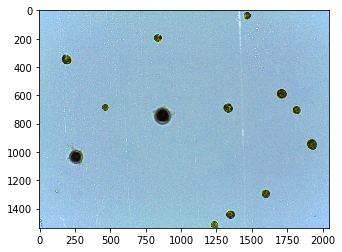

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

im = plt.imread('images/counting_hpl_1.jpg')

plt.imshow(im)

original image shape: (1536, 2048, 3)
alpha channel intensity: 211.34 +- 24.51


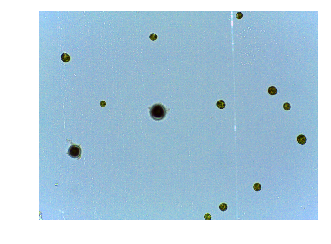

In [2]:
def my_imshow(im, title=None, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    plt.figure(figsize=(5,5))
    plt.imshow(im, interpolation='none', **kwargs)
    if title:
        plt.title(title)
    plt.axis('off')

print ('original image shape: {}'.format(im.shape))
print ('alpha channel intensity: {0:.2f} +- {1:.2f}'.format(np.mean(im[:,:,-1]), np.std(im[:,:,-1]))
)
my_imshow(im)

First, convert from color (4 channel, actually) to grayscale.

grayscale image shape: (1536, 2048)


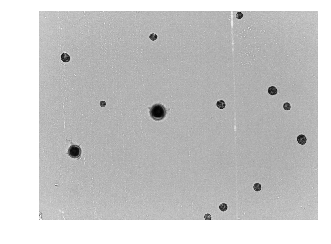

In [3]:
from skimage import color

# convert to gray 
gray_im = color.rgb2gray(im)
print ('grayscale image shape:', gray_im.shape)

my_imshow(gray_im)

Blur slightly to reduce noise. (This isn't strictly necessary in this case, since it's a fairly high-quality image.)

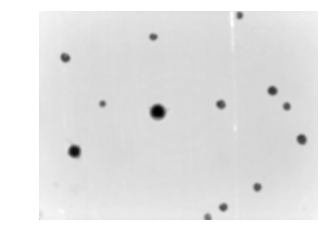

In [4]:
from skimage import filters
blurred_im = filters.gaussian(gray_im, sigma=10)
my_imshow(blurred_im)

After the image is suitable pre-processed, we can threshold it to convert it to a cell mask.

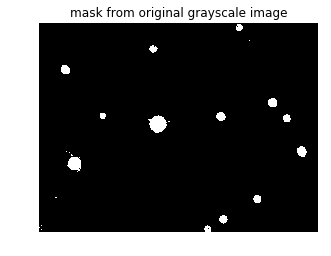

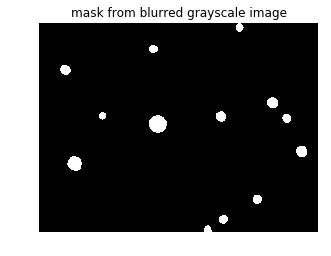

In [5]:
thresh = 0.6
mask = gray_im < thresh
blurred_mask = blurred_im < thresh

my_imshow(mask, title='mask from original grayscale image')
my_imshow(blurred_mask, title='mask from blurred grayscale image')

Binary images are manipulated with morphological operations. Morphological operations allow us to expand the white regions, shrink the white regions, fill in holes, and more. In this case, we simply want to remove the tiny dots.

Some of the cells are touching, so they appear as one object, but we would like to identify them as separate objects. This is a very common problem in segmentation problems, noteably cell tracking. A common approach is to perform a distance transform, followed by a watershed segmentation.

The distance transform converts a binary mask (black-and-white image) into a floating point image (grayscale image) of the same size. Each pixel in the distance transform represents the distance of that pixel from the nearest black point in the mask. Thus, the brighest points in the distance transform are the points that are furthest from object boundaries. An example will help clarify.

If we've done everything right, the peaks of the distance transform image represent the centers of each cell (including those that overlap). We label each separate peak with a unique integer with skimage.measure.label.

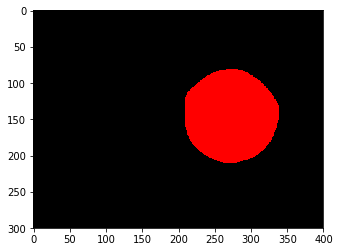

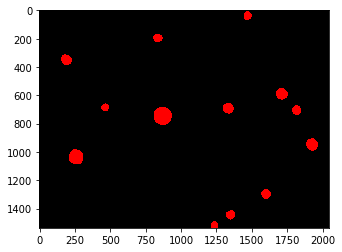

In [6]:
from skimage import feature, measure
from matplotlib.colors import ListedColormap

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


peaks_im = feature.peak_local_max(blurred_mask, indices=False)

plt.figure()
imshow_overlay(blurred_mask[600:900, 600:1000], peaks_im[600:900, 600:1000], alpha=1, cmap='gray')
plt.figure()

imshow_overlay(blurred_mask, peaks_im, alpha=1, cmap='gray')

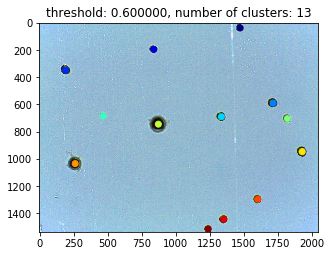

In [11]:
import scipy.cluster.hierarchy as hcluster

markers_im = measure.label(peaks_im)

properties = measure.regionprops(markers_im)
hpl_centroids = [prop.centroid for prop in properties]

hpl_array = np.asarray(hpl_centroids)

plt.figure(figsize=(5,5))
plt.imshow(im, interpolation='none', cmap='jet')

num_centroids =len(hpl_centroids)

plt.scatter(hpl_array[:,1], hpl_array[:,0], c=range(0, num_centroids), cmap='jet')


title = "threshold: %f, number of clusters: %d" % (thresh,num_centroids )

plt.title(title)
plt.show()




http://morphogenie.fr/segmenting-nuclei.html
